In [12]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import time


##  metrics

In [3]:
%cd '/home/ubuntu/logohunter/src/'
import metrics as mm

/home/ubuntu/logohunter/src


For each file, load ground truth masks and predictions

In [4]:
img_list, bbox_list_true = mm.read_txt_file('data_test.txt')
img_list_pred, bbox_list_pred = mm.read_txt_file('data_test_pred.txt')

In [5]:
list(map(len, [img_list_pred, img_list, bbox_list_true, bbox_list_pred]))

[2590, 2590, 2590, 2590]

In [6]:
print('TP: {}, FP: {}, FN: {}'.format(*mm.count_tpfpfn_from_bboxes(bbox_list_true, bbox_list_pred, conf_thr=0.5, iou_thr=0.5)))

TP: 4764, FP: 720, FN: 3253


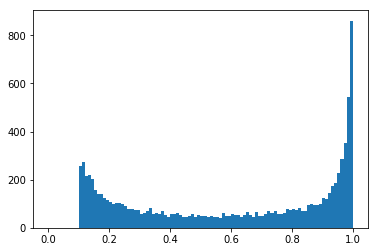

In [7]:
plt.hist([bb[-1] for r in bbox_list_pred for bb in r], bins=np.arange(0,1.01,0.01));

In [8]:
iou_thr_list = np.arange(0.1,0.91,0.1)
prec, rec = mm.prec_recalls_from_bboxes(bbox_list_true, bbox_list_pred, conf_thr_list = np.arange(0,1.01,0.01), iou_thr_list = iou_thr_list)
# prec1, rec1 = mm.prec_recalls_from_bboxes(bbox_list_true, bbox_list_pred, conf_thr_list = np.arange(0.3,1.01,0.1), iou_thr_list = [0.5])


Mean Average Precision: IoU_min = 0.1, mAP=0.75
Mean Average Precision: IoU_min = 0.2, mAP=0.72
Mean Average Precision: IoU_min = 0.3, mAP=0.71
Mean Average Precision: IoU_min = 0.4, mAP=0.68
Mean Average Precision: IoU_min = 0.5, mAP=0.64
Mean Average Precision: IoU_min = 0.6, mAP=0.57
Mean Average Precision: IoU_min = 0.7, mAP=0.42
Mean Average Precision: IoU_min = 0.8, mAP=0.20
Mean Average Precision: IoU_min = 0.9, mAP=0.02


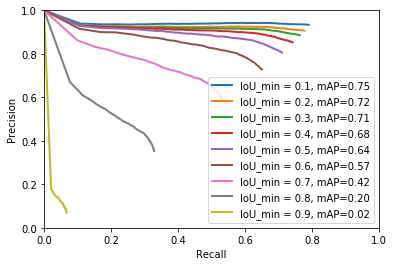

In [9]:
plt.gca().set(xlim=(0,1), ylim=(0,1), xlabel='Recall', ylabel='Precision')
for i in range(len(prec)):
    auc = np.trapz(prec[i], rec[i])
    lbl = 'IoU_min = {:.1f}, mAP={:.2f}'.format(iou_thr_list[i], auc)
    print('Mean Average Precision: {}'.format(lbl))
    plt.plot(rec[i], prec[i], label = lbl, lw=2)
#     plt.scatter(rec1[i], prec1[i])
plt.legend();

In [10]:
bb1 = bbox_list_true[0][0]
bb2 = bbox_list_pred[0][0]
bb1, bb2

([92, 43, 116, 78, 0], [350, 140, 368, 148, 0, 0.9631204])

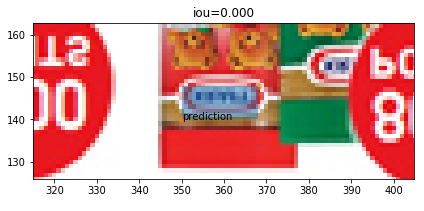

In [15]:
import matplotlib as mpl
plt.imshow(cv2.imread(img_list[0])[:,:,(2,1,0)])
for i, bb in enumerate([bb1, bb2]):
    plt.scatter([bb[0],bb[2]],[bb[1],bb[3]], alpha = 0.5)
    plt.gca().add_patch(mpl.patches.Rectangle((bb[0], bb[1]) ,bb[2]-bb[0], bb[3]-bb[1], alpha=0.5))
    plt.gca().annotate(['truth', 'prediction'][i], (bb[0],bb[1]))
plt.xlim(0.9*bb[0], 1.1*bb[2])
plt.ylim(0.9*bb[1], 1.1*bb[3])
plt.title('iou={:.3f}'.format(mm.iou_from_bboxes(bb1,bb2)))
plt.gcf().tight_layout();

True positives: 35 - False Positives: 15, False Negatives: 9
Precision: 0.700 - Recall:0.795


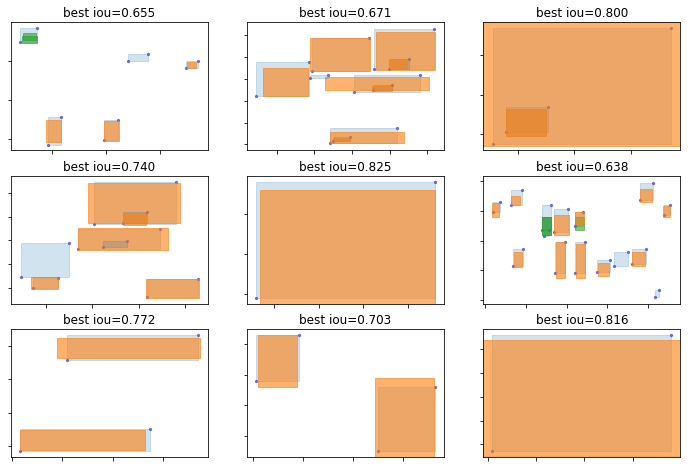

In [18]:
tp, fp, tpfp, fn = 0, 0, 0, 0
fig, axes = plt.subplots(3,3, figsize=(12,8))
match_dict = { i:{} for i in range(9)}
for i in range(9):#range(len(bbox_list_pred)):
    # axes[i//3, i%3].imshow(cv2.imread(img_list_pred[i])[:,:,(2,1,0)])
    for j, bb1 in enumerate(bbox_list_true[i]):
        axes[i//3, i%3].set(xticklabels='',yticklabels='')
        axes[i//3, i%3].scatter([bb1[0],bb1[2]],[bb1[1],bb1[3]], alpha = 0.5, c='b',s=5)
        axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb1[0], bb1[1]), 
            bb1[2]-bb1[0], bb1[3]-bb1[1], alpha=0.2, color=plt.get_cmap('tab10')(0)))
        for k, bb2 in enumerate(bbox_list_pred[i]):            
            if j in match_dict[i]:
                continue
            iou = mm.iou_from_bboxes(bb1, bb2)
            if iou == 0:
                continue
            if iou > 0.5:
                tp += 1
                match_dict[i][j] = k
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(1)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(mm.iou_from_bboxes(bb1,bb2)))
            elif iou > 0.1:
                fp += 1
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(2)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(mm.iou_from_bboxes(bb1,bb2)))
            else:
                fp += 1
    fn += len(bbox_list_true[i]) - len(match_dict[i])
print('True positives: {} - False Positives: {}, False Negatives: {}'.format(tp, fp, fn))
print('Precision: {:.3f} - Recall:{:.3f}'.format(tp/(tp+fp), tp/(tp+fn)))

True positives: 35 - False Positives: 15, False Negatives: 9
Precision: 0.700 - Recall:0.795


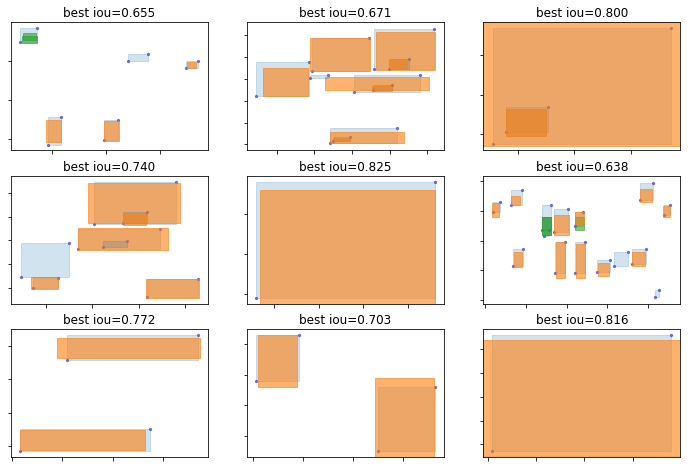

In [19]:
tp, fp, fn = 0, 0, 0
fig, axes = plt.subplots(3,3, figsize=(12,8))
match_dict = { i:{} for i in range(9)}
for i in range(9):#range(len(bbox_list_pred)):
    # axes[i//3, i%3].imshow(cv2.imread(img_list_pred[i])[:,:,(2,1,0)])
    for j, bb1 in enumerate(bbox_list_true[i]):
        axes[i//3, i%3].set(xticklabels='',yticklabels='')
        axes[i//3, i%3].scatter([bb1[0],bb1[2]],[bb1[1],bb1[3]], alpha = 0.5, c='b',s=5)
        axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb1[0], bb1[1]), 
            bb1[2]-bb1[0], bb1[3]-bb1[1], alpha=0.2, color=plt.get_cmap('tab10')(0)))
        for k, bb2 in enumerate(bbox_list_pred[i]):            
            if j in match_dict[i]:
                continue
            iou = mm.iou_from_bboxes(bb1, bb2)
            if iou == 0:
                continue
            if iou > 0.5:
                tp += 1
                match_dict[i][j] = k
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(1)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(mm.iou_from_bboxes(bb1,bb2)))
            elif iou > 0.1:
                fp += 1
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(2)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(mm.iou_from_bboxes(bb1,bb2)))
            else:
                fp += 1
    fn += len(bbox_list_true[i]) - len(match_dict[i])
print('True positives: {} - False Positives: {}, False Negatives: {}'.format(tp, fp, fn))
print('Precision: {:.3f} - Recall:{:.3f}'.format(tp/(tp+fp), tp/(tp+fn)))

Blue: True --- Yellow: predictions with IoU >= 0.5, Green: Predictions with IoU > 0.1

The dictionary holds the mapping between truth and predicted.    
For _each image index_, I have a mapping between **true boxes** and **matching predicted boxes**

To get the false negatives, pick the number of true boxes minus the number of matches

In [20]:
[(k, v, len(v)) for k,v in match_dict.items()]

[(0, {0: 4, 1: 2, 3: 0}, 3),
 (1, {0: 2, 1: 1, 2: 5, 3: 7, 4: 3, 5: 8, 6: 0, 7: 6}, 8),
 (2, {0: 1, 1: 0}, 2),
 (3, {0: 0, 1: 3, 2: 2, 3: 4, 4: 1}, 5),
 (4, {0: 0}, 1),
 (5,
  {0: 0, 1: 9, 2: 1, 3: 12, 4: 2, 7: 18, 8: 14, 9: 10, 11: 11, 12: 6, 13: 5},
  11),
 (6, {0: 0, 1: 1}, 2),
 (7, {0: 0, 1: 2}, 2),
 (8, {0: 0}, 1)]

If there are multiple predictions overlapping on the same ground truth, the previous algorithm picked the highest confidence. What happens if we pick the highest IoU?

True positives: 35 - False Positives: 15, False Negatives: 9
Precision: 0.700 - Recall:0.795


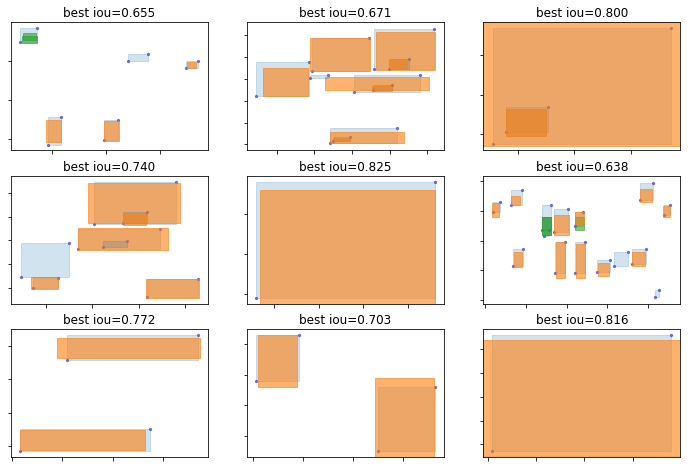

In [21]:
tp, fp, fn = 0, 0, 0
fig, axes = plt.subplots(3,3, figsize=(12,8))
match_dict = { i:{} for i in range(9)}
for i in range(9):#range(len(bbox_list_pred)):
    # axes[i//3, i%3].imshow(cv2.imread(img_list_pred[i])[:,:,(2,1,0)])
    for j, bb1 in enumerate(bbox_list_true[i]):
        axes[i//3, i%3].set(xticklabels='',yticklabels='')
        axes[i//3, i%3].scatter([bb1[0],bb1[2]],[bb1[1],bb1[3]], alpha = 0.5, c='b',s=5)
        axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb1[0], bb1[1]), 
            bb1[2]-bb1[0], bb1[3]-bb1[1], alpha=0.2, color=plt.get_cmap('tab10')(0)))
        for k, bb2 in enumerate(bbox_list_pred[i]):            
            
            iou = mm.iou_from_bboxes(bb1, bb2)
            if j in match_dict[i] and match_dict[i][j][-1] > iou:
                # skip if already found other object with larger IoU
                continue
            if iou == 0:
                continue
            if iou > 0.5:
                tp += 1
                match_dict[i][j] = (k,iou)
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(1)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(mm.iou_from_bboxes(bb1,bb2)))
            elif iou > 0.1:
                fp += 1
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(2)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(mm.iou_from_bboxes(bb1,bb2)))
            else:
                fp += 1
    fn += len(bbox_list_true[i]) - len(match_dict[i])
print('True positives: {} - False Positives: {}, False Negatives: {}'.format(tp, fp, fn))
print('Precision: {:.3f} - Recall:{:.3f}'.format(tp/(tp+fp), tp/(tp+fn)))